# Лабораторная работа № 1

**Создание матрицы и проверка продуктивности**

In [65]:
pip install networkx matplotlib

In [66]:
import math
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [67]:
file_name1 = 'BEL_NIOT_nov16.xlsx'
df_B = pd.read_excel(file_name1, sheet_name='National IO-tables')

In [68]:
df_B.columns

Index(['Year', 'Code', 'Description', 'Origin', 'A01', 'A02', 'A03', 'B',
       'C10-C12', 'C13-C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22',
       'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31_C32',
       'C33', 'D35', 'E36', 'E37-E39', 'F', 'G45', 'G46', 'G47', 'H49', 'H50',
       'H51', 'H52', 'H53', 'I', 'J58', 'J59_J60', 'J61', 'J62_J63', 'K64',
       'K65', 'K66', 'L68', 'M69_M70', 'M71', 'M72', 'M73', 'M74_M75', 'N',
       'O84', 'P85', 'Q', 'R_S', 'T', 'U', 'CONS_h', 'CONS_np', 'CONS_g',
       'GFCF', 'INVEN', 'EXP', 'GO'],
      dtype='object')

In [69]:
file_name2 = 'POL_NIOT_nov16.xlsx'
df_P = pd.read_excel(file_name2, sheet_name='National IO-tables')

Функция упрощения дата фрейма, возвращает список наименований

In [70]:
def simpl_df(df):
  df = df[df['Year'] == 2014]
  df = df[df['Origin'] == "Domestic"]
  descr = list(df["Description"])
  df = df.drop(columns=["Year", "Description", 'Origin'])
  indexes = list(df[df["GO"] == 0]["Code"])
  for i in indexes:
    df = df[df["Code"] != i]
  df = df.drop(columns=indexes)
  lst = list(df["Code"])
  df = df.drop(columns=["Code"])
  return lst, df, descr

Функция создания матриц A и D

In [71]:
def matrix_construction(df):
  div = df["GO"].to_numpy(dtype=np.float64)
  df = df.drop(columns=['CONS_h',
       'CONS_np', 'CONS_g', 'GFCF', 'INVEN', 'EXP', 'GO'])
  Z = df.to_numpy(dtype=np.float64)
  A = np.divide(Z, div)
  ident_matr = np.eye(len(A))
  D = ident_matr - A
  return A, D, df, div

Функция проверки на продуктивность

In [72]:
def productiv(D):
  flag = True
  for i in range(1, len(D) + 1):
    submatrix = D[:i, :i]
    dtr = np.linalg.det(submatrix)
    if dtr < 0:
      flag = False
      print("Матрица не продуктивна")
      break
  if flag:
    print("Матрица продуктивна")

БЕЛЬГИЯ

In [73]:
lst_B, df_B, descr_B = simpl_df(df_B)
A_B, D_B, df_B, x_B = matrix_construction(df_B)
productiv(D_B)

Матрица продуктивна


ПОЛЬША

In [74]:
lst_P, df_P, descr_P = simpl_df(df_P)
A_P, D_P, df_P, x_P = matrix_construction(df_P)
productiv(D_P)

Матрица продуктивна


**Анализ связей первого и второго порядка**

Составим словарь кодов и названий отраслей

In [75]:
Names = {}
for i in range(0, len(lst_B)):
  Names[lst_B[i]] = descr_B[i]
for key, value in Names.items():
    print(key, value)

A01 Crop and animal production, hunting and related service activities
A02 Forestry and logging
A03 Fishing and aquaculture
B Mining and quarrying
C10-C12 Manufacture of food products, beverages and tobacco products
C13-C15 Manufacture of textiles, wearing apparel and leather products
C16 Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials
C17 Manufacture of paper and paper products
C18 Printing and reproduction of recorded media
C19 Manufacture of coke and refined petroleum products 
C20 Manufacture of chemicals and chemical products 
C21 Manufacture of basic pharmaceutical products and pharmaceutical preparations
C22 Manufacture of rubber and plastic products
C23 Manufacture of other non-metallic mineral products
C24 Manufacture of basic metals
C25 Manufacture of fabricated metal products, except machinery and equipment
C26 Manufacture of computer, electronic and optical products
C27 Manufacture of electrical

Связи первого порядка характеризует матрицы $A$. Далее составляется вектор $connect1$ показывающий вес вершин. Также необходимо оборвать ненужные связи путём ввода порогового значения и рассматривать только те связи, где $a_{i,j} > eps$

In [76]:
def graph_drow(connect, A, lst, descr, contry, n_con, eps):
  scale = 150
  connect = [x * scale for x in connect]
  cond = A > eps
  bin_matr = np.where(cond, 1, 0) #матрица смежности
  pare = []
  for i in range(bin_matr.shape[0]):
    for j in range(bin_matr.shape[1]):
      if bin_matr[i][j] == 1 and i != j:
        pare.append((lst[i], lst[j]))
  fig = plt.figure(figsize=(8, 8))
  fig.suptitle(f"{contry}. Связи {n_con} порядка", fontsize=16)
  G = nx.DiGraph(directed=True)
  G.add_nodes_from(lst)
  G.add_edges_from(pare)
  options = {
      'node_color': 'red',     # color of node
      'node_size': connect,          # size of node
      'width': 0.5,                 # line width of edges
      'arrowstyle': '->',        # array style for directed graph
      'arrowsize': 18,            # size of arrow
      'edge_color':'blue',        # edge color
  }
  pos = nx.circular_layout(G)
  nx.draw(G, pos, arrows=True, with_labels = True, **options)

  diction = {}
  for i in range(0, len(lst)):
    diction[descr[i]] = connect[i]

  bigger = sorted(diction.items(), key=lambda x: x[1], reverse=True)
  print("Топ отраслей с наибольшими связями")
  for i in range(5):
    print(bigger[i])

  small = sorted(diction.items(), key=lambda x: x[1], reverse=False)
  print("Топ отраслей с наименьшими связями")
  for i in range(5):
    print(small[i])

  return small

БЕЛЬГИЯ. Связи 1 порядка

Топ отраслей с наибольшими связями
('Legal and accounting activities; activities of head offices; management consultancy activities', 254.8484780805082)
('Administrative and support service activities', 188.0317290040736)
('Wholesale trade, except of motor vehicles and motorcycles', 158.15979267193492)
('Warehousing and support activities for transportation', 126.32462462211703)
('Financial service activities, except insurance and pension funding', 107.79300487152958)
Топ отраслей с наименьшими связями
('Activities of households as employers; undifferentiated goods- and services-producing activities of households for own use', 0.015848076852580557)
('Fishing and aquaculture', 0.0902336521511608)
('Water transport', 0.51182018501875)
('Mining and quarrying', 1.274786087832191)
('Manufacture of textiles, wearing apparel and leather products', 1.386868950839645)


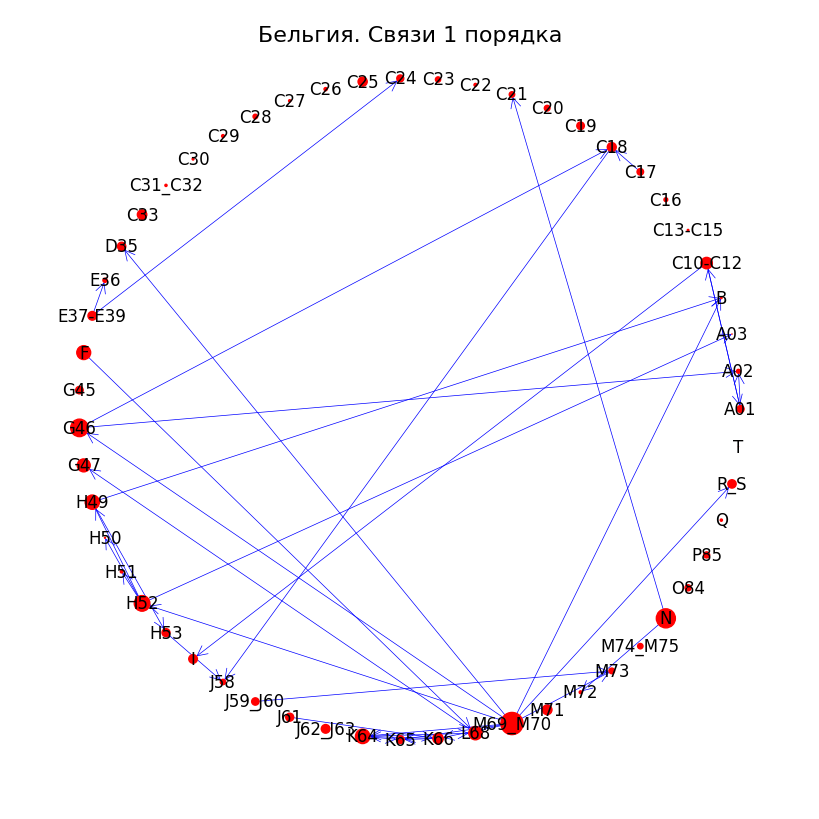

In [77]:
connect_1B = [np.sum(row) - row[i] for i, row in enumerate(A_B)]
small_B_1 = graph_drow(connect_1B, A_B, lst_B, descr_B, "Бельгия", 1, 0.05)

БЕЛЬГИЯ. Связи 2 порядка

Топ отраслей с наибольшими связями
('Legal and accounting activities; activities of head offices; management consultancy activities', 124.60492519819321)
('Administrative and support service activities', 78.23568721443591)
('Financial service activities, except insurance and pension funding', 55.63223373864553)
('Construction', 53.76834236416258)
('Real estate activities', 47.781220435045576)
Топ отраслей с наименьшими связями
('Activities of households as employers; undifferentiated goods- and services-producing activities of households for own use', 0.003732040363178676)
('Fishing and aquaculture', 0.03442112545831025)
('Water transport', 0.2040324705343817)
('Mining and quarrying', 0.33112091625326606)
('Manufacture of textiles, wearing apparel and leather products', 0.359074081383383)


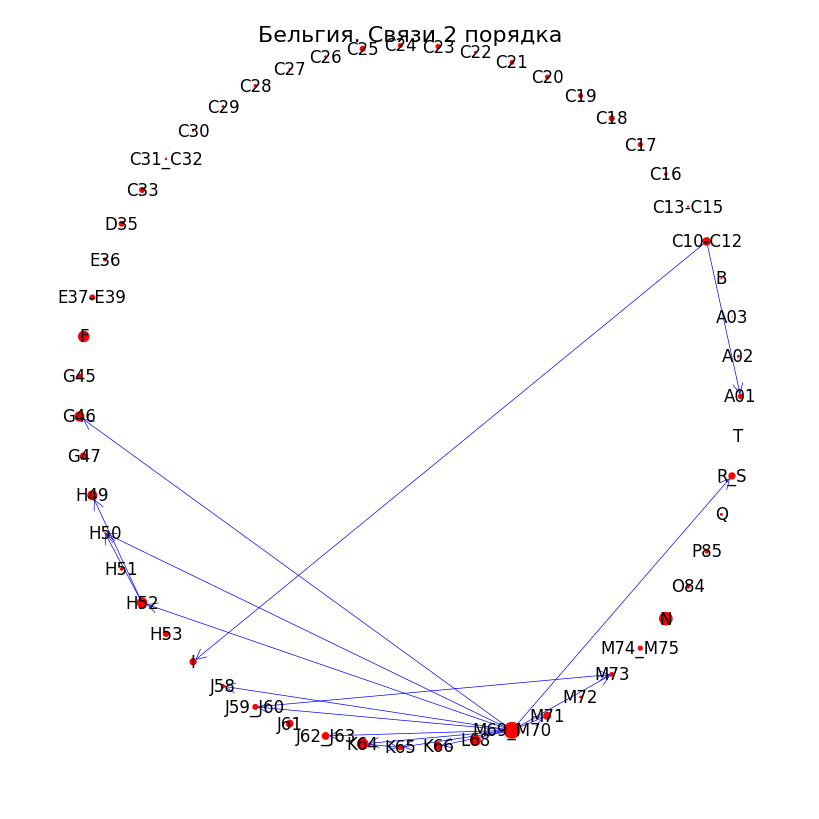

In [78]:
AA_B = np.dot(A_B, A_B)
connect_2B = [np.sum(row) - row[i] for i, row in enumerate(AA_B)]
small_B_2 = graph_drow(connect_2B, AA_B, lst_B, descr_B, "Бельгия", 2, 0.02)

ПОЛЬША. Связи первого порядка

In [79]:
Names_P = {}
for i in range(0, len(lst_P)):
  Names_P[lst_P[i]] = descr_P[i]
for key, value in Names_P.items():
    print(key, value)

A01 Crop and animal production, hunting and related service activities
A02 Forestry and logging
A03 Fishing and aquaculture
B Mining and quarrying
C10-C12 Manufacture of food products, beverages and tobacco products
C13-C15 Manufacture of textiles, wearing apparel and leather products
C16 Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials
C17 Manufacture of paper and paper products
C18 Printing and reproduction of recorded media
C19 Manufacture of coke and refined petroleum products 
C20 Manufacture of chemicals and chemical products 
C21 Manufacture of basic pharmaceutical products and pharmaceutical preparations
C22 Manufacture of rubber and plastic products
C23 Manufacture of other non-metallic mineral products
C24 Manufacture of basic metals
C25 Manufacture of fabricated metal products, except machinery and equipment
C26 Manufacture of computer, electronic and optical products
C27 Manufacture of electrical

Топ отраслей с наибольшими связями
('Wholesale trade, except of motor vehicles and motorcycles', 212.70282542724289)
('Land transport and transport via pipelines', 170.82841779097146)
('Electricity, gas, steam and air conditioning supply', 153.60504418087177)
('Manufacture of coke and refined petroleum products ', 140.63633130419177)
('Construction', 137.61377008669862)
Топ отраслей с наименьшими связями
('Activities of households as employers; undifferentiated goods- and services-producing activities of households for own use', 0.0)
('Fishing and aquaculture', 0.35166295185286006)
('Scientific research and development', 1.9024266995582497)
('Air transport', 2.3370685056209)
('Manufacture of computer, electronic and optical products', 3.32030512528435)


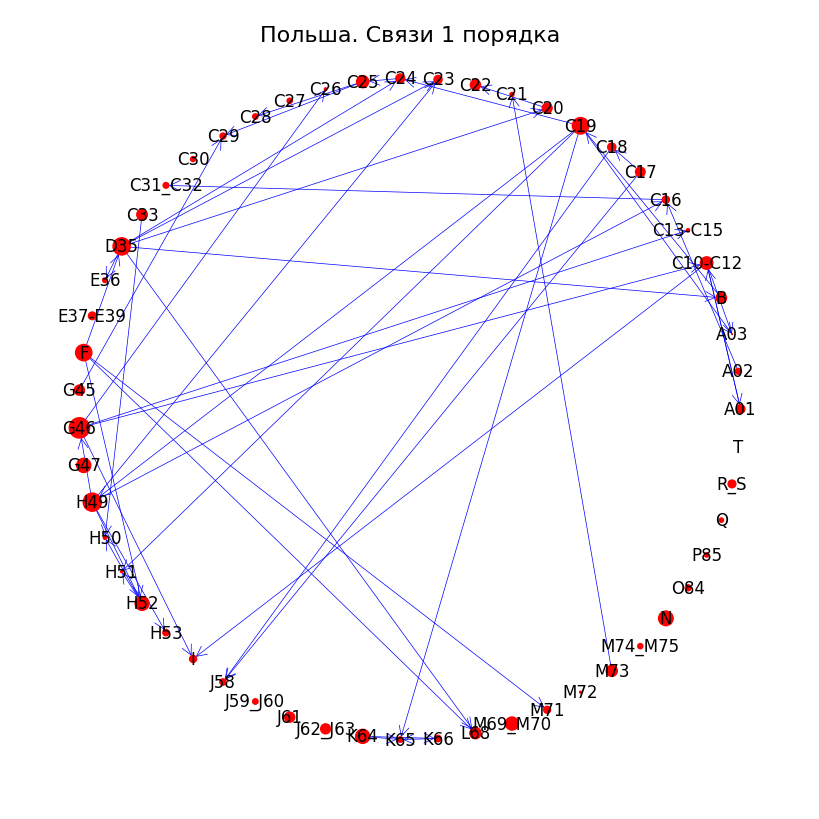

In [80]:
connect_1P = [np.sum(row) - row[i] for i, row in enumerate(A_P)]
small_P_1 = graph_drow(connect_1P, A_P, lst_P, descr_P, "Польша", 1, 0.05)

ПОЛЬША. Связи 2 порядка

Топ отраслей с наибольшими связями
('Land transport and transport via pipelines', 88.72319737457377)
('Construction', 82.94805983263642)
('Wholesale trade, except of motor vehicles and motorcycles', 81.73106294737363)
('Manufacture of coke and refined petroleum products ', 67.38103334845158)
('Electricity, gas, steam and air conditioning supply', 60.424399213251846)
Топ отраслей с наименьшими связями
('Activities of households as employers; undifferentiated goods- and services-producing activities of households for own use', 0.0)
('Fishing and aquaculture', 0.18569222881175024)
('Scientific research and development', 0.6491181360390054)
('Air transport', 0.990726606164333)
('Manufacture of computer, electronic and optical products', 1.1599236887158908)


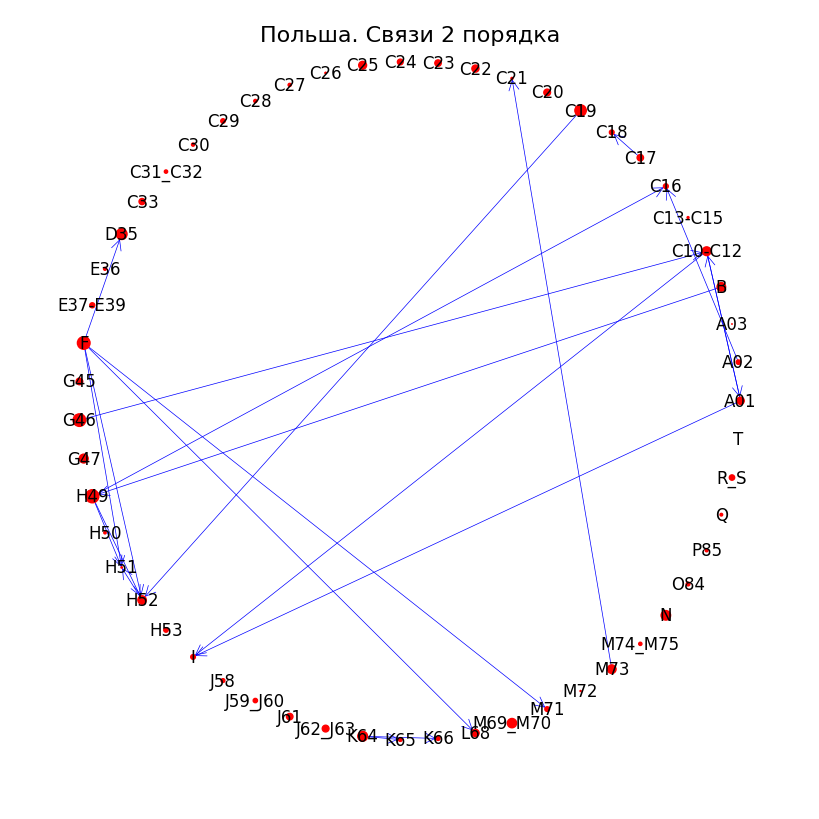

In [81]:
AA_P = np.dot(A_P, A_P)
connect_2P = [np.sum(row) - row[i] for i, row in enumerate(AA_P)]
small_P_2 = graph_drow(connect_2P, AA_P, lst_P, descr_P, "Польша", 2, 0.02)

# Исключение отраслей

Будем удалять те отрасли которые нименьшим образом связаны с остальными

In [82]:
print(A_B.shape)

(55, 55)


In [83]:
print(A_P.shape)

(55, 55)


Будем убирать 10 отраслей

In [84]:
def del1_f(small, descr, A, x):
  idx = []
  for i in range(10):
    idx.append(descr.index(small[i][0]))
  descr_d = [item for i, item in enumerate(descr) if i not in idx]
  x_d = [item for i, item in enumerate(x) if i not in idx]
  del_sm = A
  del_sm = np.delete(del_sm, idx, 0)
  del_sm = np.delete(del_sm, idx, 1)
  return del_sm, descr_d, x_d

**Бельгия**

In [85]:
del_B1, descr_B_d1, x_d_B1 = del1_f(small_B_1, descr_B, A_B, x_B)
print(del_B1.shape)
print(len(descr_B_d1))

(45, 45)
46


**Польша**

In [86]:
del_P1, descr_P_d1, x_d_P1 = del1_f(small_P_1, descr_P, A_P, x_P)
print(del_B1.shape)

(45, 45)


Теперь будем удалять по связям второго порядка

In [87]:
del_B2, descr_B_d2, x_d_B2 = del1_f(small_B_2, descr_B, A_B, x_B)
print(del_B2.shape)

(45, 45)


In [88]:
del_P2, descr_P_d2, x_d_P2 = del1_f(small_P_2, descr_P, A_P, x_P)
print(del_P2.shape)

(45, 45)


Далее попробуем удалять отрасли из произвольного списка

In [89]:
list_to_del = ["Fishing and aquaculture", "Forestry and logging", "Crop and animal production, hunting and related service activities",
                 "Other professional, scientific and technical activities; veterinary activities", "Other service activities"]

In [90]:
def del2_f(lst_d, descr, A, x):
  idx = []
  for i in range(len(lst_d)):
    idx.append(descr.index(lst_d[i]))
  descr_d = [item for i, item in enumerate(descr) if i not in idx]
  x_d = [item for i, item in enumerate(x) if i not in idx]
  del_sm = A
  del_sm = np.delete(del_sm, idx, 0)
  del_sm = np.delete(del_sm, idx, 1)
  return del_sm, descr_d, x_d

In [91]:
del_B3, descr_B_d3, x_d_B3 = del2_f(list_to_del, descr_B, A_B, x_B)
print(del_B3.shape)

(50, 50)


In [92]:
del_P3, descr_P_d3, x_d_P3 = del2_f(list_to_del, descr_P, A_P, x_P)
print(del_P3.shape)

(50, 50)


# Агрегация

Агрегирование производят в зависимости от цели анализа таблиц. Будем разделять отрасли по группам следующим образом: \\
1) Оказывающие большое влияние на экспорт \\
2) Оказывающие большое влияние на импорт(они одинаковые с 1) \\
3) Финансы \\
4) Локальные монополии \\
5) Транспорт \\
6) Остальные мелкие отрасли

Рассмотрим все изначальные отрасли до удаления. Далее будем менять списки, удаляя ненужные отрасли.

In [93]:
descr_B.pop()
print(len(descr_B))
print(len(x_B))

55
55


In [94]:
bel_ag1 = ["Legal and accounting activities; activities of head offices; management consultancy activities",
           "Manufacture of basic metals",
           "Manufacture of food products, beverages and tobacco products", "Manufacture of motor vehicles, trailers and semi-trailers",
           "Wholesale trade, except of motor vehicles and motorcycles",
           "Manufacture of coke and refined petroleum products ", "Manufacture of chemicals and chemical products "]
print(len(bel_ag1))

7


In [95]:
for i in bel_ag1:
  if i in descr_B:
    print("YES")

YES
YES
YES
YES
YES
YES
YES


In [96]:
bel_ag3 = ["Financial service activities, except insurance and pension funding", "Insurance, reinsurance and pension funding, except compulsory social security",
           "Activities auxiliary to financial services and insurance activities", "Real estate activities", "Advertising and market research"]
print(len(bel_ag3))

5


In [97]:
bel_ag4 = ["Mining and quarrying", "Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials",
           "Printing and reproduction of recorded media", "Manufacture of basic pharmaceutical products and pharmaceutical preparations", "Manufacture of rubber and plastic products",
           "Manufacture of other non-metallic mineral products", "Manufacture of fabricated metal products, except machinery and equipment",
           "Manufacture of furniture; other manufacturing", "Electricity, gas, steam and air conditioning supply",
           "Water collection, treatment and supply", "Construction", "Postal and courier activities", "Accommodation and food service activities",
           "Telecommunications", "Computer programming, consultancy and related activities; information service activities",
           "Architectural and engineering activities; technical testing and analysis", "Scientific research and development", "Administrative and support service activities",
           "Public administration and defence; compulsory social security", "Education", "Human health and social work activities"]
print(len(bel_ag4))

21


In [98]:
for i in bel_ag4:
  if i in bel_ag1 or i in bel_ag3:
    print("oops")

In [99]:
bel_ag5 = ["Wholesale and retail trade and repair of motor vehicles and motorcycles", "Retail trade, except of motor vehicles and motorcycles", "Land transport and transport via pipelines",
           "Water transport", "Air transport", "Warehousing and support activities for transportation"]
print(len(bel_ag5))

6


In [100]:
for i in bel_ag5:
  if i in bel_ag1 or i in bel_ag3 or i in bel_ag4:
    print("oops")

In [101]:
bel_ag6 = [x for x in descr_B if x not in bel_ag1 and x not in bel_ag3 and x not in bel_ag4 and x not in bel_ag5]
print(len(bel_ag6))
for i in bel_ag6:
  print(i)

16
Crop and animal production, hunting and related service activities
Forestry and logging
Fishing and aquaculture
Manufacture of textiles, wearing apparel and leather products
Manufacture of paper and paper products
Manufacture of computer, electronic and optical products
Manufacture of electrical equipment
Manufacture of machinery and equipment n.e.c.
Manufacture of other transport equipment
Repair and installation of machinery and equipment
Sewerage; waste collection, treatment and disposal activities; materials recovery; remediation activities and other waste management services 
Publishing activities
Motion picture, video and television programme production, sound recording and music publishing activities; programming and broadcasting activities
Other professional, scientific and technical activities; veterinary activities
Other service activities
Activities of households as employers; undifferentiated goods- and services-producing activities of households for own use


In [102]:
for i in bel_ag6:
  if i in bel_ag1 or i in bel_ag3 or i in bel_ag4 or i in bel_ag5:
    print("oops")

In [103]:
def agrigation(x_d, del_matr, del_descr, ag1, ag2, ag3, ag4, ag5):
  idx1 = []
  idx2 = []
  idx3 = []
  idx4 = []
  idx5 = []

  def ind(descr, ag):
    idx = []
    for i in range(len(ag)):
      if ag[i] in descr:
        idx.append(descr.index(ag[i]))
    return idx

  idx1 = ind(del_descr, ag1)
  idx2 = ind(del_descr, ag2)
  idx3 = ind(del_descr, ag3)
  idx4 = ind(del_descr, ag4)
  idx5 = ind(del_descr, ag5)
  Agr = np.zeros((5, 5))
  all = [idx1, idx2, idx3, idx4, idx5]
  sum = 0
  for i in range(len(all)):
    for j in range(len(all)):
      for m in range(len(all[i])):
        for n in range(len(all[j])):
          Agr[i][j] += del_matr[m][n] * x_d[n]
          sum += x_d[n]
      Agr[i][j] = Agr[i][j] / sum
      sum = 0
  return Agr

**Бельгия**

In [104]:
Agr_B1 = agrigation(x_d_B1, del_B1, descr_B_d1, bel_ag1, bel_ag3, bel_ag4, bel_ag5, bel_ag6)

In [105]:
print(Agr_B1)

[[0.02386008 0.03546359 0.01070761 0.03743874 0.01573883]
 [0.0290114  0.04821657 0.01258948 0.05094186 0.01865398]
 [0.01048974 0.01528679 0.00665736 0.01601191 0.00773006]
 [0.03417718 0.05773317 0.01469729 0.06241934 0.02182028]
 [0.01578015 0.02327871 0.00763095 0.02455528 0.01096714]]


In [122]:
Agr_B2 = agrigation(x_d_B2, del_B2, descr_B_d2, bel_ag1, bel_ag3, bel_ag4, bel_ag5, bel_ag6)
print(Agr_B2)

[[0.02386008 0.03546359 0.01090621 0.03546359 0.01446682]
 [0.0290114  0.04821657 0.0128245  0.04821657 0.01712586]
 [0.01107714 0.0161469  0.00712668 0.0161469  0.00823135]
 [0.0290114  0.04821657 0.0128245  0.04821657 0.01712586]
 [0.0157737  0.02325301 0.00868653 0.02325301 0.01094611]]


In [124]:
Agr_B3 = agrigation(x_d_B3, del_B3, descr_B_d3, bel_ag1, bel_ag3, bel_ag4, bel_ag5, bel_ag6)
print(Agr_B3)

[[0.01660892 0.02317113 0.00742764 0.02287053 0.01116549]
 [0.01878583 0.03107793 0.00805767 0.03016093 0.0122303 ]
 [0.00664598 0.0091299  0.00471799 0.00904254 0.00517175]
 [0.01641256 0.02673012 0.00708978 0.02637454 0.01070794]
 [0.01117124 0.01547357 0.00554534 0.01527923 0.00806839]]


**Польша**

In [108]:
descr_P.pop()
print(len(descr_P))
print(len(x_P))

55
55


In [109]:
pol_ag1 = ["Manufacture of food products, beverages and tobacco products", "Manufacture of electrical equipment", "Manufacture of motor vehicles, trailers and semi-trailers",
           "Wholesale trade, except of motor vehicles and motorcycles", "Retail trade, except of motor vehicles and motorcycles"]

In [110]:
print(len(pol_ag1))

5


In [111]:
pol_ag2 = ["Construction", "Manufacture of computer, electronic and optical products", "Manufacture of fabricated metal products, except machinery and equipment",
           "Manufacture of rubber and plastic products", "Manufacture of chemicals and chemical products ", "Manufacture of coke and refined petroleum products "]

In [112]:
print(len(pol_ag2))

6


In [113]:
pol_ag3 = [item for item in bel_ag3 if item not in pol_ag1 and item not in pol_ag2]
print(len(pol_ag3))

5


In [115]:
pol_ag4 = [item for item in bel_ag4 if item not in pol_ag1 and item not in pol_ag2]
pol_ag4.append("Legal and accounting activities; activities of head offices; management consultancy activities")
pol_ag4.append("Manufacture of basic metals")
print(len(pol_ag4))

20


In [116]:
pol_ag5 = [item for item in bel_ag5 if item not in pol_ag1 and item not in pol_ag2]
print(len(pol_ag5))

5


In [117]:
pol_ag6 = [item for item in bel_ag6 if item not in pol_ag1 and item not in pol_ag2]
print(len(pol_ag6))

14


In [118]:
def agrigation2(x_d, del_matr, del_descr, ag1, ag2, ag3, ag4, ag5, ag6):
  idx1 = []
  idx2 = []
  idx3 = []
  idx4 = []
  idx5 = []
  idx6 = []

  def ind(descr, ag):
    idx = []
    for i in range(len(ag)):
      if ag[i] in descr:
        idx.append(descr.index(ag[i]))
    return idx

  idx1 = ind(del_descr, ag1)
  idx2 = ind(del_descr, ag2)
  idx3 = ind(del_descr, ag3)
  idx4 = ind(del_descr, ag4)
  idx5 = ind(del_descr, ag5)
  idx6 = ind(del_descr, ag6)
  Agr = np.zeros((6, 6))
  all = [idx1, idx2, idx3, idx4, idx5, idx6]
  sum = 0
  for i in range(len(all)):
    for j in range(len(all)):
      for m in range(len(all[i])):
        for n in range(len(all[j])):
          Agr[i][j] += del_matr[m][n] * x_d[n]
          sum += x_d[n]
      Agr[i][j] = Agr[i][j] / sum
      sum = 0
  return Agr

In [120]:
Agr_P1 = agrigation2(x_d_P1, del_P1, descr_P_d1, pol_ag1, pol_ag2, pol_ag3, pol_ag4, pol_ag5, pol_ag6)
print(Agr_P1)

[[0.0575714  0.0575714  0.0575714  0.02720133 0.03701645 0.03759903]
 [0.0575714  0.0575714  0.0575714  0.02720133 0.03701645 0.03759903]
 [0.0575714  0.0575714  0.0575714  0.02720133 0.03701645 0.03759903]
 [0.02152023 0.02152023 0.02152023 0.01655312 0.01528957 0.01793394]
 [0.04944888 0.04944888 0.04944888 0.02638084 0.03994216 0.0358933 ]
 [0.02993835 0.02993835 0.02993835 0.01904226 0.02066269 0.02484504]]


In [121]:
Agr_P2 = agrigation2(x_d_P2, del_P2, descr_P_d2, pol_ag1, pol_ag2, pol_ag3, pol_ag4, pol_ag5, pol_ag6)
print(Agr_P2)

[[0.0575714  0.0575714  0.0575714  0.02720133 0.03701645 0.03759903]
 [0.0575714  0.0575714  0.0575714  0.02720133 0.03701645 0.03759903]
 [0.0575714  0.0575714  0.0575714  0.02720133 0.03701645 0.03759903]
 [0.02152023 0.02152023 0.02152023 0.01655312 0.01528957 0.01793394]
 [0.04944888 0.04944888 0.04944888 0.02638084 0.03994216 0.0358933 ]
 [0.02993835 0.02993835 0.02993835 0.01904226 0.02066269 0.02484504]]


In [123]:
Agr_P3 = agrigation2(x_d_P3, del_P3, descr_P_d3, pol_ag1, pol_ag2, pol_ag3, pol_ag4, pol_ag5, pol_ag6)
print(Agr_P3)

[[0.03177649 0.03144611 0.03177649 0.01624375 0.03177649 0.02752375]
 [0.02684146 0.02682638 0.02684146 0.01383504 0.02684146 0.02342336]
 [0.03177649 0.03144611 0.03177649 0.01624375 0.03177649 0.02752375]
 [0.01097525 0.01094267 0.01097525 0.01092161 0.01097525 0.01069517]
 [0.03177649 0.03144611 0.03177649 0.01624375 0.03177649 0.02752375]
 [0.0199959  0.01999088 0.0199959  0.01291855 0.0199959  0.01991094]]


**ВЫВОДЫ**

Матрицы преобразованные по первому и второму типу очень схожи для обеих стран. Для Польши они вообще почти одинаковы тк в ней связи первого и второго понрядка схожи по результатам наименьшего вклада. Ну и впринципе для обеих стран они похожи тк удалЯли отрасли, которые давали наименьший вклад. Ситуация меняется в третьем случае. Тут удаление отраслей основывалось на предположении, какие отравсли наименее развиты в этих странах. Именно поэтому последние матрицы так отличаются от первой и второй.

# Число и вектор Фробениуса-Перона

Для начала реализуем степенной метод поиска максимального собственного значения матрицы и соответствующего собственного вектора

In [133]:
def Power_Meth(matr, x0, eps, max_iter):
#x0 -вектор столбец
    y_prev = x0
    lam_prev = 0
    for i in range(max_iter):
      y = matr @ y_prev
      lam = (y.T @ y_prev) / (y_prev.T @ y_prev)
      if np.abs(lam - lam_prev) < eps:
        break
      y_prev = y
      lam_prev = lam
    return lam, y

**Бельгия**

In [135]:
x0 = np.ones(len(A_B[0])).T
lam_B, y_B = Power_Meth(A_B, x0, 1e-6, 100)
print(lam_B)
print(y_B)

0.36348746472222043
[1.02902239e-06 5.58817410e-08 3.80384478e-09 2.68026259e-08
 3.41119018e-06 3.22357652e-08 3.19264043e-07 4.80973428e-07
 9.23003190e-07 5.47526923e-07 4.71711845e-07 5.88474149e-07
 8.38576175e-08 1.10776862e-06 4.34245073e-07 1.07531214e-06
 1.03252400e-07 5.61068977e-08 2.15240693e-07 1.00578597e-07
 3.83776984e-08 5.06962666e-08 9.10931893e-07 1.02012733e-06
 2.46489541e-07 6.07255836e-07 8.02604538e-06 8.64840388e-07
 3.62083820e-06 1.81992738e-06 3.02354908e-06 1.93534055e-08
 2.30990266e-07 3.40503880e-06 1.16176371e-06 1.79402584e-06
 4.28361187e-07 1.06981799e-06 3.50293353e-06 2.79893414e-06
 6.75116477e-06 9.90410746e-07 2.90640752e-06 4.84925141e-06
 1.34505087e-05 2.73074128e-06 1.19307137e-07 6.25973910e-07
 8.77343930e-07 7.58801128e-06 4.94501023e-07 5.49576012e-07
 1.39361551e-07 1.84616484e-06 3.14083564e-10]


In [136]:
#матрица удаления первым способом
x0 = np.ones(len(del_B1[0])).T
lam_del1_B, y_del1_B = Power_Meth(del_B1, x0, 1e-6, 100)
print(lam_del1_B)
print(y_del1_B)

0.3616917833351996
[6.79563924e-10 3.66575414e-11 2.24570591e-09 2.08787732e-10
 3.16684236e-10 6.09179099e-10 3.43551182e-10 3.09147009e-10
 3.85888698e-10 5.45718146e-11 7.31602063e-10 2.79246270e-10
 6.98373199e-10 6.61583753e-11 1.38111352e-10 6.54417670e-11
 5.78761038e-10 6.70314679e-10 1.61029868e-10 3.98834040e-10
 5.28653849e-09 5.65939658e-10 2.36794712e-09 1.18935468e-09
 1.96994146e-09 2.17019609e-09 7.65178380e-10 1.16657108e-09
 2.82176787e-10 7.09750871e-10 2.32313881e-09 1.85026796e-09
 4.45272001e-09 6.49805849e-10 1.91785200e-09 3.18863239e-09
 8.85263300e-09 1.79613951e-09 7.85165708e-11 4.12606264e-10
 5.81194583e-10 4.96252608e-09 3.25354372e-10 3.59760973e-10
 1.21167636e-09]


In [137]:
#матрица удаления вторым способом
x0 = np.ones(len(del_B2[0])).T
lam_del2_B, y_del2_B = Power_Meth(del_B2, x0, 1e-6, 100)
print(lam_del2_B)
print(y_del2_B)

0.36234850563671994
[2.56942033e-10 1.37683507e-11 8.50945864e-10 7.85886974e-11
 1.18703987e-10 2.29332679e-10 1.35300815e-10 1.16553299e-10
 1.44492329e-10 2.75800285e-10 1.05197160e-10 2.64963137e-10
 2.53268959e-11 5.28663583e-11 2.47650637e-11 2.23587235e-10
 2.51981646e-10 6.09110761e-11 1.49767944e-10 1.99683923e-09
 2.13812454e-10 8.94555255e-10 4.49213760e-10 7.45857749e-10
 5.72076557e-11 8.38890612e-10 2.88332491e-10 4.44982511e-10
 1.06372454e-10 2.66572172e-10 8.72628494e-10 6.96211970e-10
 1.67767624e-09 2.44833618e-10 7.22696571e-10 1.20266048e-09
 3.33637107e-09 6.75344136e-10 1.55395583e-10 2.17821281e-10
 1.87537848e-09 1.22363647e-10 1.32743744e-10 3.45707287e-11
 4.58239055e-10]


In [138]:
#матрица удаления третьим способом
x0 = np.ones(len(del_B3[0])).T
lam_del3_B, y_del3_B = Power_Meth(del_B3, x0, 1e-6, 100)
print(lam_del3_B)
print(y_del3_B)

0.3505112861264902
[2.95232948e-11 2.66232356e-09 3.32433614e-11 3.69731741e-10
 4.86874637e-10 9.24739425e-10 5.67217732e-10 4.93681708e-10
 6.30487484e-10 9.00526513e-11 1.27399022e-09 5.00146217e-10
 1.20693288e-09 1.11071930e-10 5.96952083e-11 2.30282037e-10
 1.06832663e-10 4.22816977e-11 5.34795432e-11 9.71151247e-10
 1.07358924e-09 2.56078053e-10 6.73851416e-10 9.16893774e-09
 9.07593906e-10 3.65793954e-09 1.82175225e-09 3.14063714e-09
 2.06165329e-11 2.52627727e-10 3.68147099e-09 1.18022704e-09
 1.85093925e-09 4.50814475e-10 1.06732529e-09 3.98321907e-09
 3.13241589e-09 7.37180446e-09 1.06211891e-09 3.19723017e-09
 5.19691444e-09 1.45171415e-08 2.98934185e-09 1.29813176e-10
 6.52035223e-10 8.07536043e-09 4.20714618e-10 5.90240962e-10
 1.49815274e-10 3.12970282e-13]


In [139]:
#матрица агрегации первым способом
x0 = np.ones(len(Agr_B1[0])).T
lam_agr1_B, y_agr1_B = Power_Meth(Agr_B1, x0, 1e-6, 100)
print(lam_agr1_B)
print(y_agr1_B)

0.1451278031348734
[5.38711470e-05 7.09973757e-05 2.37901187e-05 8.54517373e-05
 3.56487121e-05]


In [140]:
#матрица агрегации вторым способом
x0 = np.ones(len(Agr_B2[0])).T
lam_agr2_B, y_agr2_B = Power_Meth(Agr_B2, x0, 1e-6, 100)
print(lam_agr2_B)
print(y_agr2_B)

0.13186892477062206
[3.60209363e-05 4.73136175e-05 1.70389618e-05 4.73136175e-05
 2.41191909e-05]


In [141]:
#матрица агрегации третьим способом
x0 = np.ones(len(Agr_B3[0])).T
lam_agr3_B, y_agr3_B = Power_Meth(Agr_B3, x0, 1e-6, 100)
print(lam_agr3_B)
print(y_agr3_B)

0.08141863454978648
[3.53224091e-06 4.44714546e-06 1.45229768e-06 3.86499021e-06
 2.39099730e-06]


**выводы**

Число Фробениуса-Перона отличается от начального при удалении отраслей третьим способом, тк удаление происходило произвольным образом. При агрегации получили совершенно другие знаечния, однако для первых двух способов они были похожи опять же по причине, указанной выше. Однако это нормально, что знаечения разошлись с первоначальными, тк разделение отраслей происходит взависимости от цели. В нашем случае, разделение происходило по количеству капитала и целям его использования в отраслях.

**Польша**

In [142]:
x0 = np.ones(len(A_P[0])).T
lam_P, y_P = Power_Meth(A_P, x0, 1e-6, 100)
print(lam_P)
print(y_P)

0.4117995003307395
[2.59524867e-09 5.11474136e-10 1.24974185e-11 2.35675042e-09
 3.15811293e-09 9.46582197e-11 6.61217159e-10 1.01816795e-09
 5.58896190e-10 4.04548335e-09 1.33447454e-09 8.16886662e-11
 1.54394759e-09 1.46847767e-09 9.21007470e-10 1.75148913e-09
 6.13790215e-11 2.80671871e-10 2.85264459e-10 6.11284208e-10
 2.74047554e-10 2.67298893e-10 1.03884446e-09 3.27233410e-09
 2.24176739e-10 6.95685610e-10 5.00024934e-09 1.22904585e-09
 4.50100575e-09 2.26503747e-09 4.77322764e-09 1.52092522e-10
 4.96647141e-11 1.97508720e-09 5.29418259e-10 5.88075565e-10
 3.82232278e-10 7.31615978e-10 1.08250881e-09 1.17103234e-09
 2.67527087e-09 3.96560255e-10 4.18963494e-10 1.37564955e-09
 2.33608412e-09 6.21898769e-10 3.24388608e-11 2.73058701e-09
 2.77565806e-10 2.35996563e-09 3.70725947e-10 2.30394335e-10
 1.79265103e-10 7.96441187e-10 0.00000000e+00]


In [143]:
#матрица удаления первым способом
x0 = np.ones(len(del_P1[0])).T
lam_del1_P, y_del1_P = Power_Meth(del_P1, x0, 1e-6, 100)
print(lam_del1_P)
print(y_del1_P)

0.40844703590405884
[1.88271582e-09 3.69524125e-10 1.68510878e-09 2.26970796e-09
 4.71261757e-10 7.24458412e-10 3.94187303e-10 2.87007869e-09
 9.49973676e-10 1.09871664e-09 1.05097967e-09 6.57089816e-10
 1.24989484e-09 1.97160900e-10 2.01422211e-10 4.35999541e-10
 1.89398369e-10 1.82397008e-10 7.23875816e-10 2.31394796e-09
 1.58853672e-10 4.94102577e-10 3.55122140e-09 8.73010221e-10
 3.18865627e-09 1.60795832e-09 3.38716924e-09 1.34493110e-09
 3.76131504e-10 4.12467109e-10 2.69148302e-10 5.20867551e-10
 7.65804380e-10 8.32716964e-10 1.89596796e-09 2.81271669e-10
 2.96865017e-10 9.67565607e-10 1.65746705e-09 4.41241608e-10
 1.93936139e-09 1.95634075e-10 1.65425870e-09 2.62081891e-10
 5.64379709e-10]


In [144]:
#матрица удаления вторым способом
x0 = np.ones(len(del_P2[0])).T
lam_del2_P, y_del2_P = Power_Meth(del_P2, x0, 1e-6, 100)
print(lam_del2_P)
print(y_del2_P)

0.40813864490148805
[1.85061225e-09 3.61714696e-10 1.64287561e-09 2.22993206e-09
 4.60144723e-10 7.12089488e-10 3.90009980e-10 2.80194267e-09
 9.26251229e-10 1.07128668e-09 1.02317558e-09 6.39578414e-10
 1.21753751e-09 1.92249315e-10 1.96317501e-10 4.25247033e-10
 1.84839863e-10 1.78886320e-10 7.05445773e-10 2.24110505e-09
 4.65802324e-10 3.45455442e-09 8.52405933e-10 3.11748066e-09
 1.57308367e-09 3.30952198e-09 1.31579326e-09 3.67149636e-10
 4.04178339e-10 2.65125436e-10 5.11177137e-10 7.49013288e-10
 8.15811669e-10 1.85676249e-09 2.74677789e-10 2.90278792e-10
 9.47639717e-10 1.62202426e-09 4.29846015e-10 1.90239600e-09
 1.91463003e-10 1.61640844e-09 2.55554134e-10 1.59967878e-10
 5.51989025e-10]


In [145]:
#матрица удаления третьим способом
x0 = np.ones(len(del_P3[0])).T
lam_del3_P, y_del3_P = Power_Meth(del_P3, x0, 1e-6, 100)
print(lam_del3_P)
print(y_del3_P)

0.39325105058168885
[3.83952113e-06 3.16725908e-06 1.43004281e-07 1.04668092e-06
 1.61394480e-06 8.72838937e-07 6.26973208e-06 1.96023294e-06
 1.05070526e-07 2.52544468e-06 2.41270509e-06 1.52457141e-06
 2.83835516e-06 9.62760719e-08 4.48545781e-07 4.56271002e-07
 1.00057649e-06 4.49397391e-07 3.95677452e-07 1.66269248e-06
 5.07717706e-06 3.51498670e-07 1.12022459e-06 8.25959445e-06
 1.89588889e-06 6.63755834e-06 3.24504581e-06 7.54347350e-06
 2.49353169e-07 8.01629477e-08 3.17410223e-06 8.51324795e-07
 9.44639397e-07 6.03908162e-07 1.26052447e-06 1.71643611e-06
 1.92778415e-06 4.21940626e-06 5.70368667e-07 6.72778298e-07
 2.14691930e-06 3.74983075e-06 1.01040701e-06 4.96643474e-08
 4.60208444e-06 3.72977422e-06 5.81159479e-07 3.71558031e-07
 2.70541334e-07 0.00000000e+00]


In [146]:
#матрица агрегации первым способом
x0 = np.ones(len(Agr_P1[0])).T
lam_agr1_P, y_agr1_P = Power_Meth(Agr_P1, x0, 1e-6, 100)
print(lam_agr1_P)
print(y_agr1_P)

0.23752212824529087
[0.00087935 0.00087935 0.00087935 0.00035083 0.00079426 0.00047993]


In [147]:
#матрица агрегации вторым способом
x0 = np.ones(len(Agr_P2[0])).T
lam_agr2_P, y_agr2_P = Power_Meth(Agr_P2, x0, 1e-6, 100)
print(lam_agr2_P)
print(y_agr2_P)

0.23752212824529087
[0.00087935 0.00087935 0.00087935 0.00035083 0.00079426 0.00047993]


In [148]:
#матрица агрегации третьим способом
x0 = np.ones(len(Agr_P3[0])).T
lam_agr3_P, y_agr3_P = Power_Meth(Agr_P3, x0, 1e-6, 100)
print(lam_agr3_P)
print(y_agr3_P)

0.14574855624536062
[7.73353202e-05 6.55254819e-05 7.73353202e-05 2.81836529e-05
 7.73353202e-05 5.01692039e-05]


Выводы

Как и в случае с Бельгией, в числа Фробениуса-Перона отличаются при агрегации. Здесь более заметно, что результаты полученные первым и вторым способом мало отличаются, это вызвано тем, что связи перовго и пторого порядка практически совпадают в Польше.